<a href="https://colab.research.google.com/github/AdithyaSrivastava01/MNISTClassification/blob/main/MNISTTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor #to transform the images to tensors
#.functional hass all kinda oss function and activation function
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [ ]:
train_dataset=MNIST(root="data/",download=True,transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
test_dataset=MNIST(root="data/",download=True,train=False,transform=ToTensor())

In [ ]:
len(train_dataset)

60000

In [ ]:
len(test_dataset)

10000

In [ ]:
train_ds,val_ds=random_split(train_dataset,(50000,10000))

In [ ]:
len(train_ds)

50000

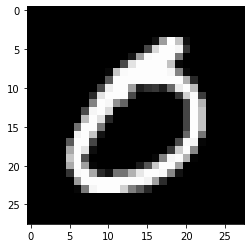

In [ ]:
img,label=train_ds[4]
plt.imshow(img[0],cmap="gray")

In [ ]:
hidden=32
input_size=784
num_classes=10

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class MNISTModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, input_size,hidden,num_classes):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(input_size, hidden)
        # output layer
        self.linear2 = nn.Linear(hidden,num_classes)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.reshape(-1, 784)#detects the default batch_size which 128 in this case and converts into feature vector of 784
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # # Get predictions using output layer
        out = self.linear2(out)
        return out
  
    
    def validation_step(self, batch):
        images, labels = batch
        images,labels=images.to(device),labels.to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device


'cuda'

In [ ]:
batch_size=128
train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size)

In [ ]:
model=MNISTModel(input_size,hidden,num_classes).to(device)
opt=torch.optim.SGD(model.parameters(), lr=0.1)
loss_fn=F.cross_entropy

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs) 

def train(epochs,train_ds,opt,loss_fn,model,val_ds):
  history=[]
  for i in range(epochs):
    for img,label in train_ds:
      img,label=img.to(device),label.to(device)
      pred=model(img)
      loss=loss_fn(pred,label)
      loss.backward()
      opt.step()
      opt.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(i, result)
    history.append(result)
  return history

    
    
    

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09236550331115723, 'val_loss': 2.3041112422943115}]

In [ ]:
train(8,train_loader,opt,loss_fn,model,val_loader)

Epoch [0], val_loss: 0.3611, val_acc: 0.8969
Epoch [1], val_loss: 0.3070, val_acc: 0.9141
Epoch [2], val_loss: 0.2805, val_acc: 0.9223
Epoch [3], val_loss: 0.2507, val_acc: 0.9318
Epoch [4], val_loss: 0.2230, val_acc: 0.9373
Epoch [5], val_loss: 0.2043, val_acc: 0.9431
Epoch [6], val_loss: 0.1944, val_acc: 0.9465
Epoch [7], val_loss: 0.1819, val_acc: 0.9495


[{'val_acc': 0.8968552350997925, 'val_loss': 0.3611161410808563},
 {'val_acc': 0.9140625, 'val_loss': 0.30700650811195374},
 {'val_acc': 0.9222705960273743, 'val_loss': 0.28050726652145386},
 {'val_acc': 0.9317642450332642, 'val_loss': 0.2507047951221466},
 {'val_acc': 0.9373022317886353, 'val_loss': 0.22297890484333038},
 {'val_acc': 0.9431368708610535, 'val_loss': 0.20429909229278564},
 {'val_acc': 0.946499228477478, 'val_loss': 0.194376140832901},
 {'val_acc': 0.9494659900665283, 'val_loss': 0.181867778301239}]

In [ ]:
img, label=test_dataset[167]

#img=ToTensor(img)
with torch.no_grad():
    #model.eval()
    pred = model(img.to(device).unsqueeze(0))
    probs=F.softmax(pred,dim=1)
    
    max_probs, preds = torch.max(probs, dim=1)
    print(preds)
    print(max_probs)
print(img.shape)

tensor([5], device='cuda:0')
tensor([0.9867], device='cuda:0')
torch.Size([1, 28, 28])


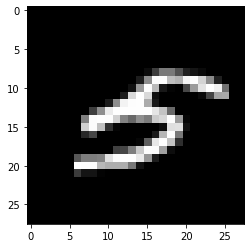

In [ ]:
plt.imshow(img[0],cmap="gray")

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
#Validation Step
accuracy=[]
with torch.no_grad():
  for img,label in val_loader:
    img,label=img.to(device),label.to(device)
    pred=model(img.unsqueeze(0))
    probs=F.softmax(pred,dim=1)
      
    max_probs, preds = torch.max(probs, dim=1)
    preds=preds.cpu().numpy()#in sci-kit lib the accuracy is measured using the numpy which only loaded into the cpu not to the gpu
    label=label.cpu().numpy()
    accuracy+=[accuracy_score(label,preds)]
  
print((accuracy))

[0.984375, 0.9375, 0.9609375, 0.9765625, 0.953125, 0.953125, 0.9375, 0.96875, 0.984375, 0.9765625, 0.9296875, 0.953125, 0.96875, 0.9609375, 0.96875, 0.921875, 0.96875, 0.9609375, 0.953125, 0.921875, 0.9296875, 0.9375, 0.9453125, 0.9296875, 0.9296875, 0.9296875, 0.96875, 0.9296875, 0.90625, 0.9296875, 0.953125, 0.9375, 0.9453125, 0.9453125, 0.9609375, 0.96875, 0.9453125, 0.953125, 0.890625, 0.9765625, 0.9140625, 0.9140625, 0.96875, 0.9375, 0.9609375, 0.9609375, 0.9296875, 0.9296875, 0.921875, 0.9609375, 0.984375, 0.9375, 0.9453125, 0.9375, 0.9921875, 0.90625, 0.953125, 0.9609375, 0.9453125, 0.9453125, 0.9296875, 0.984375, 0.9765625, 0.96875, 0.921875, 0.9921875, 0.9375, 0.9765625, 0.953125, 0.9453125, 0.9375, 0.9375, 0.9609375, 0.921875, 0.9765625, 0.953125, 0.9453125, 0.9296875, 1.0]


In [ ]:
accuracy_net=((sum(accuracy))/(len(accuracy)))*100
print("the net accuracy of model is: ",accuracy_net,"%")

the net accuracy of model is:  94.94659810126582 %
